# Exploratory data analysis

In this notebook, I'll analyse the dataset. I'll look for:  
  
- duplicates  
  
- biases  
  
- outliers  
  
- characteristics of each author, by analysing parts of speech
  

This analysis will give me a fuller picture of the data as well as any over/under-sampling and cleaning which I need to do. It'll also help me learn what features the model might learn. 

In [15]:
import sys
sys.path.append('../')
import pandas as pd
import pickle
from src import data

In [16]:
# Load the data
df = pd.read_json('../data/gutenberg-paragraphs.json')

## Analyse duplicates

First, I thought it would be interesting to see if the same text appears in both classes, which could be quite confusing for the model.

As you can see by running the code below, however, that wasn't the case. There are duplicate texts but each instance is written by the same author.

In [17]:

def appears_more_than_ones(df:pd.DataFrame)->dict:
    text_dict = {i:[0,[]]for i in df['text'].unique()}

    for text, label in zip(df['text'], df['austen']):
        text_dict[text][0] += 1
        text_dict[text][1].append(label)

    text_dict_sorted = {k:v for k,v in sorted(text_dict.items(), key=lambda x: x[1][0], reverse=True)}
    text_dict_sorted = {k:v for k,v in list(text_dict_sorted.items()) if v[0]>1}
    return text_dict_sorted

repeat_texts = appears_more_than_ones(df)
repeat_texts

{'           *                    *                   *': [4, [0, 0, 0, 0]],
 '                                             "M.D."': [2, [1, 1]],
 '   All. Double, double, toyle and trouble,\nFire burne, and Cauldron bubble': [2,
  [0, 0]]}

In [18]:
# Let's remove duplicates for the rest of the analysis
df.drop_duplicates(subset='text', inplace=True)

## Analyse bias
biases can skew the probability distribution in favour of the more common class. The model may therefore learn that it can perform well by predicting one label more frequently than another.

from running the code cell below, we see that there is a clear bias in the dataset in favour of the 0 (not Austen)

In [19]:
df['austen'].value_counts() 

austen
0    7857
1    4748
Name: count, dtype: int64

## Analyse language
I like to look at what information a model might learn, such as does Austen and non-Austen have bias to certain text lengths, terms, verbs, named entities, adjectives and so on. These could even be fed into the model as features or used as a multiplier on its predictions after inference (in the past I've had quite good results with this approach for RAG).

## Text length
In the graph below, I have calculated the probabiltiy distrubtion for the lengths of Austen vs non Austen's texts. 
You can choose to filter the outliers by setting the filter_outliers parameter to true and you can adjust the multiplier with the multipliers parameter. 

#### Results
        Before adjusting for outliers:  
  
        - Austen has outliers but not as drastic. Largest outlier is 2647    
          
        - Given a mode of 11 and mean of 75 this will still have a significant skewing affect on the distribution
            
        - Non Austen has some significant outliers, with the largest reaching a text length of 212030  
          
        - Given the mode is 11 and mean is 120 this has some skewing affects on the probability distribution.    
          
            


        After adjusting for outliers:
    
        - Austen has a more varied text length than non Austen  
  
        - both Austen and non Austen's text lengths are more commonly on the lower end of the distribution  
          
        - Austen's text are on average 20 words longer than non Austen's.  
          



In [20]:
# Add lengths to the dataframe
df = data.add_text_lengths_to_df(df)

In [21]:
df[df['austen']==0]['length'].describe()

count      7857.000000
mean        120.153112
std        3215.131213
min           1.000000
25%          19.000000
50%          33.000000
75%          65.000000
max      212030.000000
Name: length, dtype: float64

In [22]:
df[df['austen']==1]['length'].describe()

count    4748.000000
mean       75.315922
std        80.411413
min         1.000000
25%        27.000000
50%        53.000000
75%        98.000000
max      2647.000000
Name: length, dtype: float64

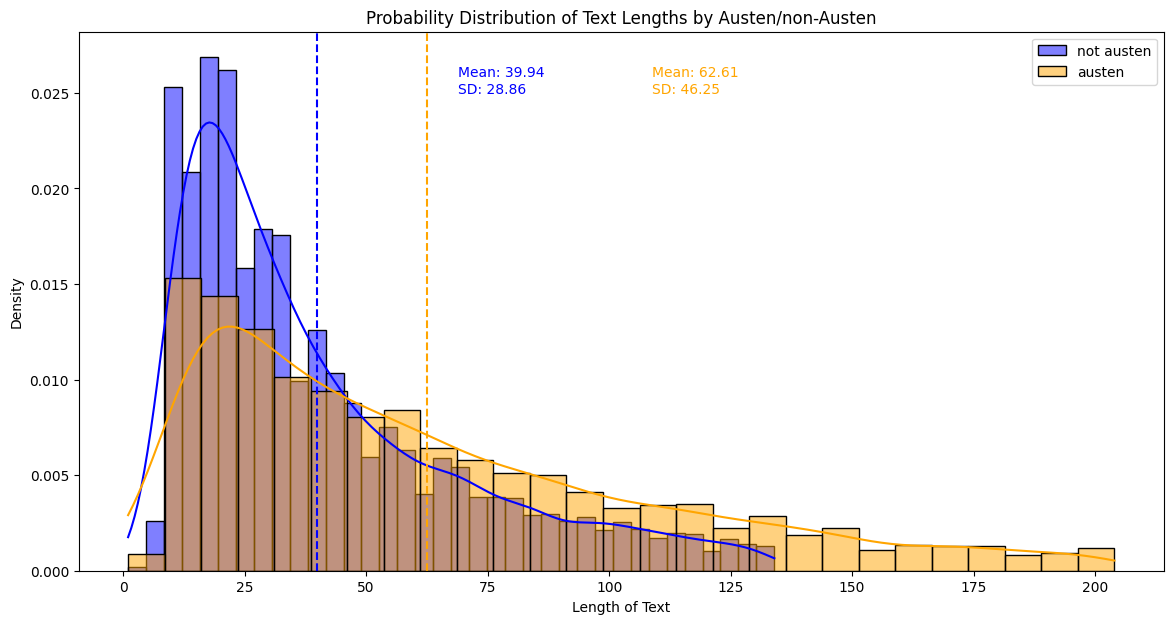

In [23]:
# plot probability density function over lenghts 
data.plot_pdf_length(df, filter_outliers=True, multiplier=1.5)

### Most frequent terms
I calculated the most frequent:  
  
    --> terms* (sklearn)
    
    --> verbs (spacy)  
    
    --> adjectives (spacy)  
    
    --> nouns (transformers) 

* - used tf-idf as it emperically learns stop words rather than selecting a generic list from nltk. I didn't have time to add the terms to the plotting function.

#### Results
    - Looking at parts of speech and their frequency, the authors’ uses of vocabulary and diversity of vocab are quite similar  
      
    - The adjectives plot does not have much on the x-axis because I filtered for stop words. If I had more time I would've made it so that stop words weren't filtered when plotting adjectives.  
      

In [24]:
# most_frequent_terms_Austen = utils.get_language_data(df, 1, max_df=0.4, min_df=0.01, k=20)
# most_frequent_terms_not_Austen = utils.get_language_data(df, 0, max_df=0.4, min_df=0.01, k=20)

# with open('most_frequent_terms_Austen.pkl', 'wb') as f:
#     pickle.dump(most_frequent_terms_Austen, f)

# with open('most_frequent_terms_not_Austen.pkl', 'wb') as f:
#     pickle.dump(most_frequent_terms_not_Austen, f)

In [25]:
with open('../data/austen_term_freq.pkl', 'rb') as f:
    austen_term_freq = pickle.load(f)

with open('../data/not_austen_term_freq.pkl', 'rb') as f:
    non_austen_term_freq = pickle.load(f)


In [26]:
# Select a part of speech from ['verbs', adjectives', 'nouns']
part_of_speech = 'nouns'

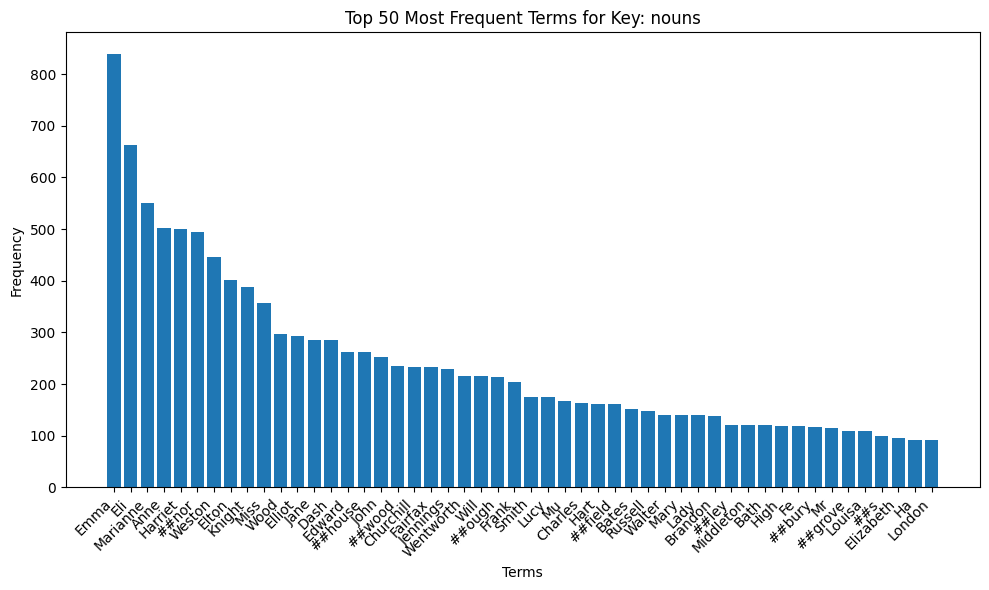

In [27]:
data.plot_term_freq(austen_term_freq, part_of_speech, k=50)

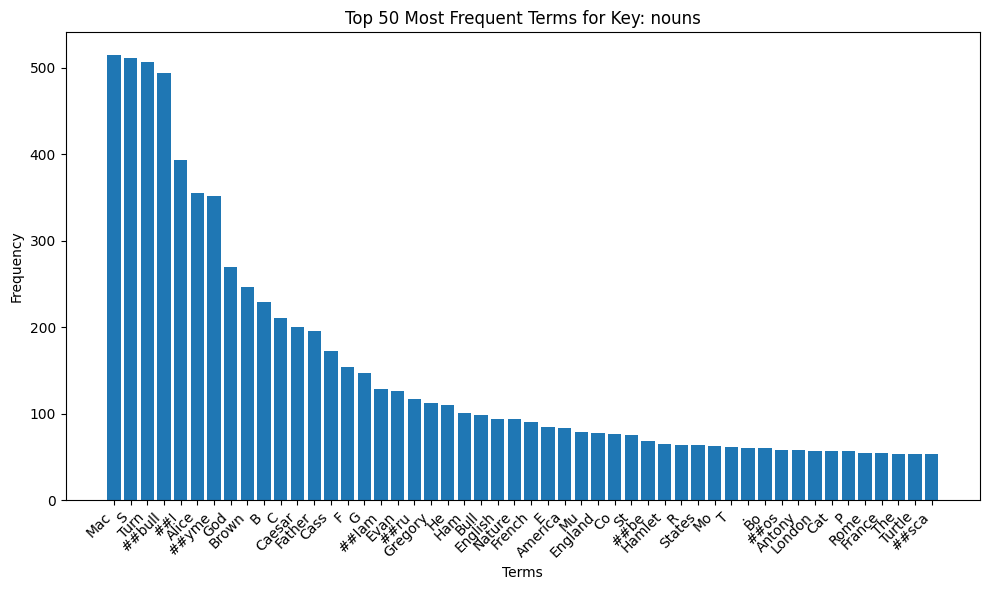

In [28]:
data.plot_term_freq(non_austen_term_freq, part_of_speech, k=50)